In [2]:
import gym_super_mario_bros
import tensorflow as tf
import gym
import numpy as np
import random
from collections import deque
import keras

2023-06-11 20:07:53.211761: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from tensorflow.keras.layers import Dense,Activation, Flatten, Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [4]:
from gym_super_mario_bros.actions import RIGHT_ONLY
from nes_py.wrappers import JoypadSpace

In [5]:
from gym.wrappers import GrayScaleObservation
from matplotlib import pyplot as plt

In [6]:
env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = JoypadSpace(env, [['NOOP'], ['right'], ['right', 'A']])
# env = GrayScaleObservation(env, keep_dim=True)


In [7]:
from IPython import display as ipythondisplay

In [8]:
class DqnAgent:
  def __init__(self,state_size,action_size,env,skip=4):
    self.state_space = state_size
    self.action_space = action_size
    self.action=0
    self.memory = deque(maxlen=5000)
    self.skip=skip
    self.abs = 0.85
    self.max_abs=0.85
    self.min_abs=0.01
    self.decay_abs = 0.001
    self.environment=env
    self.gamma  = 0.9
    
    self.main_network = self.build_model()
    self.target_network = self.build_model()
    self.update_target()
  
  def build_model(self):
    model = Sequential()

    model.add(Conv2D(64,(4,4),strides=4,padding="same",input_shape=self.state_space))
    model.add(Activation('relu'))

    model.add(Conv2D(64,(4,4),strides=2,padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(64,(4,4),strides=2,padding='same'))
    model.add(Activation('relu'))
    model.add(Flatten())

    model.add(Dense(512,activation="relu"))
    model.add(Dense(256,activation="relu"))
    model.add(Dense(self.action_space,activation="linear"))

    model.compile(loss='mse',optimizer=Adam())
    return model

  def update_target(self):
    self.target_network.set_weights(self.main_network.get_weights())

  def act(self,state,on_ground):
    if on_ground<90:
      if random.uniform(0,1)<self.abs:
        return  env.action_space.sample()
      
      Q_value = self.main_network.predict(state)
      self.action= np.argmax(Q_value[0])
      return self.action
    else:
      return self.action


  def update_abs(self,episode):
    self.abs = self.min_abs+(self.max_abs-self.min_abs)*np.exp(-self.decay_abs*episode)

  def train(self,batch_size):
    minibatch = random.sample(self.memory,batch_size)

    for state,action,reward,next_state,done in minibatch:
      target = self.main_network.predict(state)

      if done:
        target[0][action] = reward
      else:
        target[0][action] = (reward+self.gamma*np.amax(self.target_network(next_state)))
        
      self.main_network.fit(state,target,epochs=1,verbose=0)

  def store_memory(self,state,action,reward,next_state,done):
      self.memory.append((state,action,reward,next_state,done))
    
  def save_model(self,name):
    self.main_network.save(name)
    
  def load_model(self,name):
    self.main_network = keras.models.load_model(name)
    self.target_network = keras.models.load_model(name)
    
  def step(self,action):
        t_r=0
        done = False
        for i in range(self.skip):
            state,reward,done,info = self.environment.step(action)
            t_r+=reward
            
            if done:
                break
        return state,t_r,done,info

In [9]:
from PIL import Image

In [10]:
def preprocessing(state):
  image = Image.fromarray(state)
  image = image.resize((88,80))
  image = image.convert('L')
  image = np.array(image)

  return image

In [11]:
action_space =  env.action_space.n
state_size = (80,88,1)

In [12]:
num_eps= 100
num_timestep = 4000
batch_size = 64

In [13]:
import time
from IPython.display import clear_output

dqn =  DqnAgent(state_size,action_space,env)
history= []
stuck_buffer = deque(maxlen=300)
for i in range(num_eps):
  total_reward= 0
  done =False
  time_step=0
  on_ground =79
  state = preprocessing(env.reset())
  state = state.reshape(-1,80,88,1)
  

  for t in range(num_timestep):
    time_step+=1
    env.render()
    
    if t>1  and stuck_buffer.count(stuck_buffer[-1])>150:
        action = dqn.act(state,79)
    else:
        action = dqn.act(state,on_ground)

    next_state,reward,done,info = dqn.step(action)
    on_ground = info['y_pos']
    stuck_buffer.append(info['x_pos'])
    next_state =  preprocessing(next_state)
    next_state = next_state.reshape(-1,80,88,1)

    dqn.store_memory(state,action,reward,next_state,done)
    state= next_state

    total_reward +=  reward
    if done:
      break
    print(info)
    print("episode: {} total reward: {} abs: {}".format(str(i),str(total_reward),str(dqn.abs)))
    clear_output(wait=True)

    if  len(dqn.memory)>batch_size  and i%5==0 and i!=0:
      dqn.train(batch_size)
  
  dqn.update_abs(i)
  dqn.update_target()

  if i%5==0:
        name = "v1_model_after"+str(i)+"episodes.h5"
        dqn.save_model(name)
  history.append(total_reward)
env.close()
  

{'coins': 2, 'flag_get': False, 'life': 0, 'score': 800, 'stage': 1, 'status': 'small', 'time': 0, 'world': 1, 'x_pos': 722, 'x_pos_screen': 87, 'y_pos': 93}
episode: 4 total reward: 1668.0 abs: 0.8474837762228334


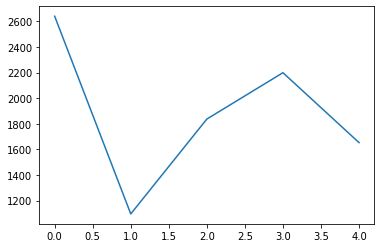

In [14]:
import matplotlib.pyplot as plt
plt.plot(history)

In [15]:
name = "v1_model_after"+str(4)+"episodes.h5"

In [ ]:
dqn =  DqnAgent(state_size,action_space,env)
dqn.load_model(name)
for i in range(10):
    total_reward= 0
    done =False
    time_step=0
    on_ground =79
    state = preprocessing(env.reset())
    state = state.reshape(-1,80,88,1)
    
    while not done:
        env.render()
        action = np.argmax(dqn.main_network.predict(state))
        next_state,reward,done,info = env.step(action)
        
        next_state = preprocessing(next_state)
        
        state = next_state
        
        total_reward+=reward
    print("episode: {} total reward: {}".format(str(i),str(total_reward)))
